/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


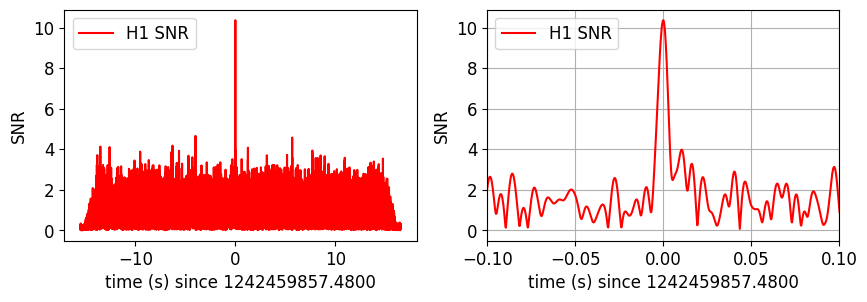

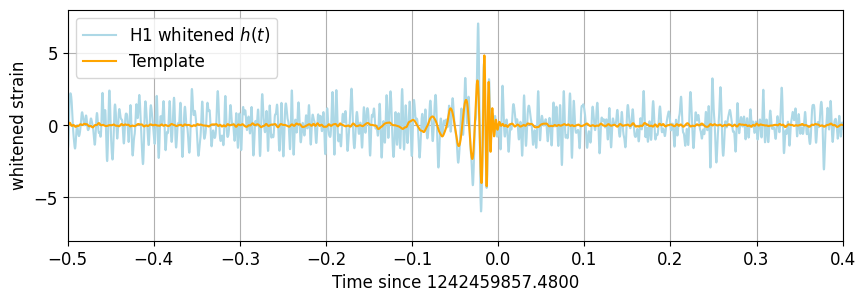

In [ ]:
import h5py#引入库
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
#白化处理
def whiten(Strain, psdInterp, Xspacing):
  StrainLen = len(Strain)
  freqs = np.fft.rfftfreq(StrainLen, Xspacing)
  StrainFreq = np.fft.rfft(Strain)
  NORM = 1. / np.sqrt(1./(Xspacing*2))
  StrainFreqWhiten = StrainFreq / np.sqrt(psdInterp(freqs)) * NORM
  StrainWhiten = np.fft.irfft(StrainFreqWhiten, n=StrainLen)
  return StrainWhiten
#读取引力波数据，压力，GPS时间，模板组
dataFile = "/root/H-H1_GWOSC_4KHZ_R1-1242459842-32.hdf5"
templateFile = "/root/GW150914_4_template.hdf5"
with h5py.File(dataFile, 'r') as data:
  Strain   = data['strain']['Strain'][...]
  GPSstart = data['meta']['GPSstart'][()]
  Xspacing = data['strain']['Strain'].attrs['Xspacing']
  Duration = data['meta']['Duration'][()]
with h5py.File(templateFile, 'r') as data:
  template = data['template'][...]
  template = template[0] + template[1]*1.j

timeSeries = np.arange(GPSstart, GPSstart+Duration, Xspacing)#时间序列
Fs   = int(1./Xspacing)#采样频率
NFFT = 4*Fs
NOVL = int(NFFT/2)#快速傅里叶变换
blkmWin  = np.blackman(NFFT)
tukeyWin = signal.windows.tukey(template.size, alpha=1./8)
templateFreq = np.fft.fftfreq(template.size) * Fs
df = templateFreq[1] - templateFreq[0]
#信号和模板的频谱分析、信噪比（SNR）的计算
templateFFT = np.fft.fft(template*tukeyWin) / Fs
StrainFFT = np.fft.fft(Strain*tukeyWin) / Fs
StrainPSD, freqs = mlab.psd(
  Strain, Fs=Fs, NFFT=NFFT, window=blkmWin, noverlap=NOVL
 )
powerVec = np.interp(np.abs(templateFreq), freqs, StrainPSD)
optimalSNR = StrainFFT * templateFFT.conjugate() / powerVec
optimalSNRTime = 2 * np.fft.ifft(optimalSNR) * Fs
normFac = 1 * (templateFFT*templateFFT.conjugate()/powerVec).sum() * df
normFac = np.sqrt(np.abs(normFac))
SNRComplex = optimalSNRTime / normFac
peakIdx = int(Strain.size/2)
SNRComplex = np.roll(SNRComplex, peakIdx)
SNR = abs(SNRComplex)
#信号噪声时间序列中的最大峰值对应的时间点
idxMax = np.argmax(SNR)
timeMax = timeSeries[idxMax]

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.ylabel("SNR")
plt.plot(timeSeries-timeMax, SNR, 'r', label="H1 SNR")
plt.xlabel("time (s) since {0:.4f}".format(timeMax))
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(timeSeries-timeMax, SNR, 'r', label="H1 SNR")
plt.xlim([-0.1,0.1])
plt.xticks([-0.1, -0.05, 0, 0.05, 0.1])
plt.xlabel("time (s) since {0:.4f}".format(timeMax))
plt.ylabel("SNR")
plt.legend(loc='upper left')
plt.grid('on')
# plt.savefig("GWDataAnalysis-SNR.pdf", bbox_inches='tight')
plt.show()


freqBand = [40.0, 300.0]
b, a = butter(4, [freqBand[0]*2./Fs,freqBand[1]*2./Fs], btype='band')
NORM = np.sqrt((freqBand[1]-freqBand[0]) / (Fs/2))

StrainPSD, freqs = mlab.psd(Strain, Fs=Fs, NFFT=NFFT)
StrainPSDInterp = interp1d(freqs, StrainPSD)
StrainWhiten = whiten(Strain, StrainPSDInterp, Xspacing)
StrainWhitenBP = filtfilt(b, a, StrainWhiten) / NORM
SNRmax = SNR[idxMax]
phase = np.angle(SNRComplex[idxMax])
offset = (idxMax-peakIdx)
templatePhaseshifted = np.real(template*np.exp(1.j*phase))
templateRolled = np.roll(templatePhaseshifted,offset) / (normFac/SNRmax)
templateWhitened = whiten(templateRolled, interp1d(freqs, StrainPSD), Xspacing)
templateMatch = filtfilt(b, a, templateWhitened) / NORM

plt.figure(figsize=(10,3))
plt.plot(timeSeries-timeMax, StrainWhitenBP, 'lightblue', label="H1 whitened $h(t)$")
plt.plot(timeSeries-timeMax, templateMatch, 'orange', label="Template")
plt.xlim([-0.5,0.4])
plt.ylim([-8,8])
plt.grid('on')
plt.xlabel("Time since {0:.4f}" .format(timeMax))
plt.ylabel("whitened strain")
plt.legend(loc='upper left')
plt.savefig("GWDataAnalysis-Match.pdf", bbox_inches='tight')
plt.show()